# **Spark Moive Recommendation**      2023/5-2023/6
In this notebook, I will use an Alternating Least Squares (ALS) algorithm with Spark APIs to predict the ratings for the movies in [MovieLens small dataset](https://grouplens.org/datasets/movielens/latest/)

# Set Up Environments

## Spark

- https://medium.com/grabngoinfo/install-pyspark-3-on-google-colab-the-easy-way-577ec4a2bcd8

In [ ]:
# Download Java Virtual Machine (JVM) and Spark
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
# Unzip the file
!tar xf spark-3.2.1-bin-hadoop3.2.tgz
# Set up the enviornment

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = '/content/spark-3.2.1-bin-hadoop3.2'
# Install library for finding Spark
!pip install -q findspark
# Import the libary
import findspark
findspark.init()
findspark.find()

from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
# Check Spark Session Information
spark
# Import a Spark function from library
from pyspark.sql.functions import col

## Libraries

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Datasets

In [ ]:
cd /content/drive/MyDrive/Projects

/content/drive/MyDrive/Projects


In [ ]:
ls

links.csv  ml-latest-small.zip  movies.csv  ratings.csv  tags.csv


In [ ]:
movies_df = spark.read.load("/content/drive/MyDrive/Projects/movies.csv", format='csv', header = True)
ratings_df = spark.read.load("/content/drive/MyDrive/Projects/ratings.csv", format='csv', header = True)
links_df = spark.read.load("/content/drive/MyDrive/Projects/links.csv", format='csv', header = True)
tags_df = spark.read.load("/content/drive/MyDrive/Projects/tags.csv", format='csv', header = True)

In [ ]:
movies_df.show(5)

+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Adventure|Animati...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|      Comedy|Romance|
|      4|Waiting to Exhale...|Comedy|Drama|Romance|
|      5|Father of the Bri...|              Comedy|
+-------+--------------------+--------------------+
only showing top 5 rows



In [ ]:
ratings_df.show(5)

+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     1|      1|   4.0|964982703|
|     1|      3|   4.0|964981247|
|     1|      6|   4.0|964982224|
|     1|     47|   5.0|964983815|
|     1|     50|   5.0|964982931|
+------+-------+------+---------+
only showing top 5 rows



In [ ]:
links_df.show(5)

+-------+-------+------+
|movieId| imdbId|tmdbId|
+-------+-------+------+
|      1|0114709|   862|
|      2|0113497|  8844|
|      3|0113228| 15602|
|      4|0114885| 31357|
|      5|0113041| 11862|
+-------+-------+------+
only showing top 5 rows



In [ ]:
tags_df.show(5)

+------+-------+---------------+----------+
|userId|movieId|            tag| timestamp|
+------+-------+---------------+----------+
|     2|  60756|          funny|1445714994|
|     2|  60756|Highly quotable|1445714996|
|     2|  60756|   will ferrell|1445714992|
|     2|  89774|   Boxing story|1445715207|
|     2|  89774|            MMA|1445715200|
+------+-------+---------------+----------+
only showing top 5 rows



In [ ]:
print('Number of null values in userid: ',ratings_df.filter(ratings_df['userId'].isNull()).count())
print('Number of null values in movieid: ',ratings_df.filter(ratings_df['movieId'].isNull()).count())
print('Number of null values in tag: ',tags_df.filter(tags_df['tag'].isNull()).count())
print('Number of null values in title: ',movies_df.filter(movies_df['title'].isNull()).count())

Number of null values in userid:  0
Number of null values in movieid:  0
Number of null values in tag:  0
Number of null values in title:  0


In [ ]:
tmp1 = ratings_df.groupBy("userID").count().toPandas()['count'].min()
tmp2 = ratings_df.groupBy("movieId").count().toPandas()['count'].min()
print('For the users that rated movies and the movies that were rated:')
print('Minimum number of ratings per user is {}'.format(tmp1))
print('Minimum number of ratings per movie is {}'.format(tmp2))

For the users that rated movies and the movies that were rated:
Minimum number of ratings per user is 20
Minimum number of ratings per movie is 1


In [ ]:
tmp1 = sum(ratings_df.groupBy("movieId").count().toPandas()['count'] == 1)
tmp2 = ratings_df.select('movieId').distinct().count()
print('{} out of {} movies are rated by only one user'.format(tmp1, tmp2))

3446 out of 9724 movies are rated by only one user


# Part 1: Spark SQL and OLAP

In [ ]:
movies_df.registerTempTable("movies")
ratings_df.registerTempTable("ratings")
links_df.registerTempTable("links")
tags_df.registerTempTable("tags")

/content/spark-3.2.1-bin-hadoop3.2/python/pyspark/sql/dataframe.py:138: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  warnings.warn(


### Q1: The number of Users

In [ ]:
# Method - 1
q1_result=spark.sql("Select Count(Distinct userId) as Number_of_Users from ratings")
q1_result.show()

+---------------+
|Number_of_Users|
+---------------+
|            610|
+---------------+



In [ ]:
# Method - 2
# all users should be computed by both ratings and tags
# in case some users leave raings but no tag while some users leave tags but no rating
nuser=spark.sql('SELECT COUNT(DISTINCT userId) ' +\
                'FROM (' +\
	                'SELECT DISTINCT userId ' +\
	                'FROM ratings ' +\
	                'UNION ' +\
	                'SELECT DISTINCT userId ' +\
	                'FROM tags' +\
                ')').toPandas()
print('Total number of users is ',nuser.iloc[0,0])

Total number of users is  610


### Q2: The number of Movies

In [ ]:
q2_result=spark.sql("Select Count(movieId) as Number_of_Moives from movies")
q2_result.show()

+----------------+
|Number_of_Moives|
+----------------+
|            9742|
+----------------+



### Q3:  How many movies are rated by users? List movies not rated before

In [ ]:
# number of movies rated
q3_result_1=spark.sql("Select Count(movieId) as Number_of_Rated_Moives From movies Where movieID in (Select movieId From ratings)")
q3_result_1.show()

+----------------------+
|Number_of_Rated_Moives|
+----------------------+
|                  9724|
+----------------------+



In [ ]:
# movies that have not been rated before: 50 movies as an example
unrated_list=spark.sql('SELECT * ' +\
                       'FROM movies ' +\
                       'WHERE movieId NOT IN ( ' +\
                        'SELECT movieId ' +\
                        'FROM ratings ' +\
                       ') ' +\
                       'LIMIT 50')
print('50 movies that have not been rated by users:')
unrated_list.show()

50 movies that have not been rated by users:
+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|   1076|Innocents, The (1...|Drama|Horror|Thri...|
|   2939|      Niagara (1953)|      Drama|Thriller|
|   3338|For All Mankind (...|         Documentary|
|   3456|Color of Paradise...|               Drama|
|   4194|I Know Where I'm ...|   Drama|Romance|War|
|   5721|  Chosen, The (1981)|               Drama|
|   6668|Road Home, The (W...|       Drama|Romance|
|   6849|      Scrooge (1970)|Drama|Fantasy|Mus...|
|   7020|        Proof (1991)|Comedy|Drama|Romance|
|   7792|Parallax View, Th...|            Thriller|
|   8765|This Gun for Hire...|Crime|Film-Noir|T...|
|  25855|Roaring Twenties,...|Crime|Drama|Thriller|
|  26085|Mutiny on the Bou...|Adventure|Drama|R...|
|  30892|In the Realms of ...|Animation|Documen...|
|  32160|Twentieth Century...|              Comedy|
|  32371|Call North

### Q4: List Movie Genres

In [ ]:
genres_list=spark.sql('select genres from movies').toPandas()
# genres_list.head(5)
spark.sql('select distinct genres from movies').show()

+--------------------+
|              genres|
+--------------------+
|Comedy|Horror|Thr...|
|Adventure|Sci-Fi|...|
|Action|Adventure|...|
| Action|Drama|Horror|
|Action|Animation|...|
|Animation|Childre...|
|Action|Adventure|...|
|    Adventure|Sci-Fi|
|Documentary|Music...|
|Adventure|Childre...|
| Adventure|Animation|
| Musical|Romance|War|
|Action|Adventure|...|
|Adventure|Childre...|
|Comedy|Crime|Horr...|
|Crime|Drama|Fanta...|
|Comedy|Mystery|Th...|
|   Adventure|Fantasy|
|Horror|Romance|Sc...|
|Drama|Film-Noir|R...|
+--------------------+
only showing top 20 rows



In [ ]:
q4_result=spark.sql("Select Distinct explode(split(genres,'[|]')) as genres From movies Order by 1")
q4_result.show()

+------------------+
|            genres|
+------------------+
|(no genres listed)|
|            Action|
|         Adventure|
|         Animation|
|          Children|
|            Comedy|
|             Crime|
|       Documentary|
|             Drama|
|           Fantasy|
|         Film-Noir|
|            Horror|
|              IMAX|
|           Musical|
|           Mystery|
|           Romance|
|            Sci-Fi|
|          Thriller|
|               War|
|           Western|
+------------------+



### Q5: Movie for Each Category

In [ ]:
# size of each category
q5_result_1=spark.sql("Select genres,Count(movieId) as Number_of_Moives From(Select explode(split(genres,'[|]')) as genres, movieId From movies) Group By 1 Order by 2 DESC")
q5_result_1.show()

+------------------+----------------+
|            genres|Number_of_Moives|
+------------------+----------------+
|             Drama|            4361|
|            Comedy|            3756|
|          Thriller|            1894|
|            Action|            1828|
|           Romance|            1596|
|         Adventure|            1263|
|             Crime|            1199|
|            Sci-Fi|             980|
|            Horror|             978|
|           Fantasy|             779|
|          Children|             664|
|         Animation|             611|
|           Mystery|             573|
|       Documentary|             440|
|               War|             382|
|           Musical|             334|
|           Western|             167|
|              IMAX|             158|
|         Film-Noir|              87|
|(no genres listed)|              34|
+------------------+----------------+



In [ ]:
# list all movie for each category
q5_result_2=spark.sql("Select genres, concat_ws(',',collect_set(title)) as list_of_movies From(Select explode(split(genres,'[|]')) as genres, title From movies) Group By 1")
q5_result_2.show()

+------------------+--------------------+
|            genres|      list_of_movies|
+------------------+--------------------+
|             Crime|Stealing Rembrand...|
|           Romance|Vampire in Brookl...|
|          Thriller|Element of Crime,...|
|         Adventure|Ice Age: Collisio...|
|             Drama|Airport '77 (1977...|
|               War|General, The (192...|
|       Documentary|The Barkley Marat...|
|           Fantasy|Masters of the Un...|
|           Mystery|Before and After ...|
|           Musical|U2: Rattle and Hu...|
|         Animation|Ice Age: Collisio...|
|         Film-Noir|Rififi (Du rififi...|
|(no genres listed)|T2 3-D: Battle Ac...|
|              IMAX|Harry Potter and ...|
|            Horror|Underworld: Rise ...|
|           Western|Man Who Shot Libe...|
|            Comedy|Hysteria (2011),H...|
|          Children|Ice Age: Collisio...|
|            Action|Stealing Rembrand...|
|            Sci-Fi|Push (2009),SORI:...|
+------------------+--------------

# Part2: Spark ALS based approach for training model
We will use an Spark ML to predict the ratings, so let's reload "ratings.csv" using ``sc.textFile`` and then convert it to the form of (user, item, rating) tuples.

## Bkgd Info

- In collaborative filtering, matrix factorization is the state-of-the-art solution for sparse data problem

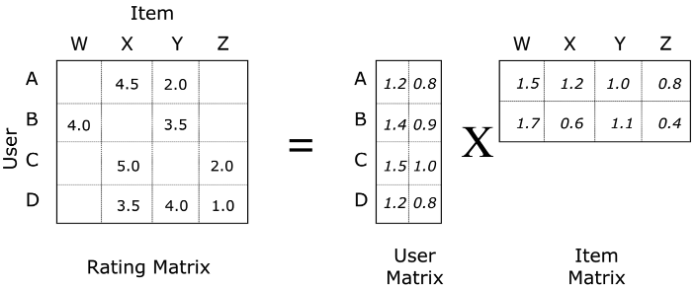

*  Hybrid Recommender System

- a matrix factorization is a factorization of a matrix into a product of matrices. In the case of collaborative filtering, matrix factorization algorithms work by decomposing the user-item interaction matrix into the product of two lower dimensionality rectangular matrices. One matrix can be seen as the user matrix where rows represent users and columns are latent factors. The other matrix is the item matrix where rows are latent factors and columns represent items.

Q: How does matrix factorization solve the problems listed in Part One?


1. Model learns to factorize rating matrix into user and movie representations, which allows model to predict better personalized movie ratings for users


2. With matrix factorization, less-known movies can have rich latent representations as much as popular movies have, which improves recommender’s ability to recommend less-known movies


Q: Why using Alternating Least Square (ALS) algorithm?


A: Alternating Least Square (ALS) is also a matrix factorization algorithm and it runs itself in a parallel fashion. ALS is implemented in Apache Spark ML and built for a larges-scale collaborative filtering problems. ALS is doing a pretty good job at solving scalability and sparseness of the Ratings data, and it’s simple and scales well to very large datasets.



## Datasets

In [ ]:
ratings_df.show()

+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     1|      1|   4.0|964982703|
|     1|      3|   4.0|964981247|
|     1|      6|   4.0|964982224|
|     1|     47|   5.0|964983815|
|     1|     50|   5.0|964982931|
|     1|     70|   3.0|964982400|
|     1|    101|   5.0|964980868|
|     1|    110|   4.0|964982176|
|     1|    151|   5.0|964984041|
|     1|    157|   5.0|964984100|
|     1|    163|   5.0|964983650|
|     1|    216|   5.0|964981208|
|     1|    223|   3.0|964980985|
|     1|    231|   5.0|964981179|
|     1|    235|   4.0|964980908|
|     1|    260|   5.0|964981680|
|     1|    296|   3.0|964982967|
|     1|    316|   3.0|964982310|
|     1|    333|   5.0|964981179|
|     1|    349|   4.0|964982563|
+------+-------+------+---------+
only showing top 20 rows



In [ ]:
movie_ratings=ratings_df.drop('timestamp')

In [ ]:
# Data type convert
from pyspark.sql.types import IntegerType, FloatType
movie_ratings = movie_ratings.withColumn("userId", movie_ratings["userId"].cast(IntegerType()))
movie_ratings = movie_ratings.withColumn("movieId", movie_ratings["movieId"].cast(IntegerType()))
movie_ratings = movie_ratings.withColumn("rating", movie_ratings["rating"].cast(FloatType()))

In [ ]:
movie_ratings.show()

+------+-------+------+
|userId|movieId|rating|
+------+-------+------+
|     1|      1|   4.0|
|     1|      3|   4.0|
|     1|      6|   4.0|
|     1|     47|   5.0|
|     1|     50|   5.0|
|     1|     70|   3.0|
|     1|    101|   5.0|
|     1|    110|   4.0|
|     1|    151|   5.0|
|     1|    157|   5.0|
|     1|    163|   5.0|
|     1|    216|   5.0|
|     1|    223|   3.0|
|     1|    231|   5.0|
|     1|    235|   4.0|
|     1|    260|   5.0|
|     1|    296|   3.0|
|     1|    316|   3.0|
|     1|    333|   5.0|
|     1|    349|   4.0|
+------+-------+------+
only showing top 20 rows



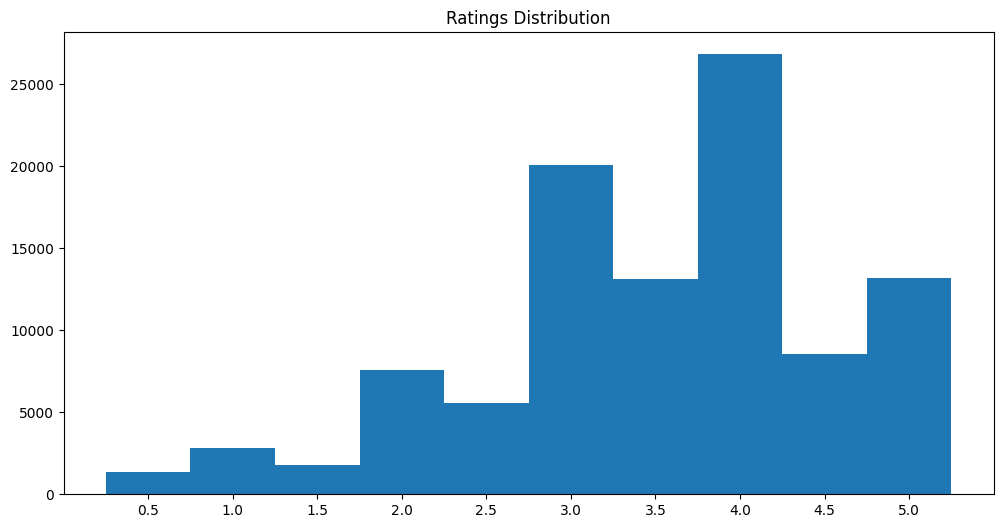

In [ ]:
# bar chart of ratings
rating_count=movie_ratings.select('rating').groupBy('rating').count().toPandas()
plt.figure(figsize=[12,6])
plt.bar(x='rating',height='count',data=rating_count,width=0.5)
plt.title('Ratings Distribution')
plt.xticks(np.arange(0.5,5.5,0.5))
plt.show()

## ALS Model Selection and Evaluation


ALS has its own set of hyper-parameters. We need to tune its hyper-parameters via hold-out validation or cross-validation.

* https://spark.apache.org/docs/2.2.0/ml-collaborative-filtering.html



Most important hyper-params in Alternating Least Square (ALS):

1. maxIter: the maximum number of iterations to run (defaults to 10);
2. rank: the number of latent factors in the model (defaults to 10);
3. regParam: the regularization parameter in ALS (defaults to 1.0);

* With the ALS model, we can use a grid search to find the optimal hyperparameters.

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import CrossValidator,ParamGridBuilder

In [ ]:

(training,test) = movie_ratings.randomSplit([0.8,0.2])

In [ ]:
#Create ALS model
model_als = ALS(maxIter=10, rank=10, regParam=1, userCol="userId", itemCol="movieId", ratingCol="rating",
          coldStartStrategy="drop", seed=6)

In [ ]:
#Tune model using ParamGridBuilder
params = ParamGridBuilder()\
            .addGrid(model_als.maxIter, [3, 5, 10])\
            .addGrid(model_als.regParam, [0.1, 0.01, 0.001])\
            .addGrid(model_als.rank, [5, 10, 15, 20, 25])\
            .addGrid(model_als.alpha, [0.1, 0.01, 0.001])\
            .build()

# Define evaluator as RMSE
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
                                predictionCol="prediction")


# Build Cross validation
cv = CrossValidator(estimator=model_als, estimatorParamMaps=params, evaluator=evaluator, numFolds=5, seed=6)


#Fit ALS model to training data
cvModel = cv.fit(training)


#Extract best model from the tuning exercise using ParamGridBuilder
bestModel=cvModel.bestModel

In [ ]:
bestModel

ALSModel: uid=ALS_fbbdeff9563e, rank=25

In [ ]:
# Check the best parameters
best_params = cvModel.getEstimatorParamMaps()[np.argmin(cvModel.avgMetrics)]
print('Best ALS model parameters by CV:')
for i,j in best_params.items():
  print('-> '+i.name+': '+str(j))

Best ALS model parameters by CV:
-> maxIter: 10
-> regParam: 0.1
-> rank: 25
-> alpha: 0.001


In [ ]:
#Extract best model from the tuning exercise using ParamGridBuilder
prediction_train=cvModel.transform(training)
rmse_train = evaluator.evaluate(prediction_train)
print("Root-mean-square error for training data is " + str(rmse_train))

Root-mean-square error for training data is 0.48347461461636626


## Model testing
And finally, make a prediction and check the testing error.

In [ ]:
#Generate predictions and evaluate using RMSE
predictions=bestModel.transform(test)
rmse = evaluator.evaluate(predictions)

In [ ]:
#Print evaluation metrics and model parameters
print ("RMSE = "+str(rmse))
print ("**Best Model**")
print (" Rank: ", str(bestModel._java_obj.parent().getRank())),
print (" MaxIter: ", str(bestModel._java_obj.parent().getMaxIter())),
print (" RegParam: ", str(bestModel._java_obj.parent().getRegParam()))

RMSE = 0.8758427622265368
**Best Model**
 Rank:  25
 MaxIter:  10
 RegParam:  0.1


In [ ]:
predictions.show()

+------+-------+------+----------+
|userId|movieId|rating|prediction|
+------+-------+------+----------+
|   133|    471|   4.0| 3.2452536|
|   362|   1645|   5.0| 3.6245685|
|   108|   1959|   5.0| 3.6549861|
|    34|   3997|   2.0| 1.5559446|
|    28|   1580|   3.0| 3.2152839|
|   436|    471|   3.0| 3.7532113|
|   332|   2366|   3.5| 3.5895798|
|   577|   1580|   3.0| 3.1676083|
|   577|   1959|   4.0| 3.3124042|
|   606|   1829|   3.5| 1.8709686|
|   606|   6466|   4.0| 3.8712986|
|   606|  44022|   4.0|  2.819061|
|    91|   1580|   3.5| 3.5220344|
|    93|   1580|   5.0| 4.4972005|
|   599|   1088|   2.5|  2.250994|
|   599|   3997|   0.5| 1.8440123|
|   599|   4519|   2.5|  2.571497|
|   599|   7340|   2.0| 2.1722326|
|   599|   8638|   3.0| 2.9762316|
|   140|   3175|   2.5| 3.2779505|
+------+-------+------+----------+
only showing top 20 rows



## Model apply and see the performance

In [ ]:
alldata = bestModel.transform(movie_ratings)
rmse = evaluator.evaluate(alldata)
print ("RMSE = "+str(rmse))

RMSE = 0.5810631491185407


In [ ]:
alldata.registerTempTable("alldata")

/content/spark-3.2.1-bin-hadoop3.2/python/pyspark/sql/dataframe.py:138: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  warnings.warn(


In [ ]:
spark.sql("Select * From alldata").show()

+------+-------+------+----------+
|userId|movieId|rating|prediction|
+------+-------+------+----------+
|   463|   1088|   3.5| 3.2349572|
|   137|   1580|   3.5|  3.522793|
|   580|   1580|   4.0|  3.747803|
|   580|   3175|   2.5| 3.1512356|
|   580|  44022|   3.5| 3.4515443|
|   133|    471|   4.0| 3.2452536|
|   322|   1580|   3.5| 3.2989304|
|   362|   1591|   4.0| 3.3385642|
|   362|   1645|   5.0| 3.6245685|
|   593|   1580|   1.5| 2.6048224|
|   597|    471|   2.0| 3.4603248|
|   597|   1580|   3.0| 3.4562068|
|   597|   1959|   4.0| 3.9559321|
|   597|   2366|   5.0| 4.4374223|
|   108|   1959|   5.0| 3.6549861|
|   155|   1580|   4.0|  3.833286|
|   155|   3175|   4.0| 3.7995005|
|    34|   1580|   2.5| 2.8371298|
|    34|   3997|   2.0| 1.5559446|
|   368|   1580|   3.0|  3.103555|
+------+-------+------+----------+
only showing top 20 rows



In [ ]:
spark.sql('SELECT * ' +\
          'FROM movies ' +\
	          'JOIN alldata ON movies.movieId = alldata.movieId').show()

+-------+--------------------+--------------------+------+-------+------+----------+
|movieId|               title|              genres|userId|movieId|rating|prediction|
+-------+--------------------+--------------------+------+-------+------+----------+
|   1088|Dirty Dancing (1987)|Drama|Musical|Rom...|   463|   1088|   3.5| 3.2349572|
|   1580|Men in Black (a.k...|Action|Comedy|Sci-Fi|   137|   1580|   3.5|  3.522793|
|   1580|Men in Black (a.k...|Action|Comedy|Sci-Fi|   580|   1580|   4.0|  3.747803|
|   3175| Galaxy Quest (1999)|Adventure|Comedy|...|   580|   3175|   2.5| 3.1512356|
|  44022|Ice Age 2: The Me...|Adventure|Animati...|   580|  44022|   3.5| 3.4515443|
|    471|Hudsucker Proxy, ...|              Comedy|   133|    471|   4.0| 3.2452536|
|   1580|Men in Black (a.k...|Action|Comedy|Sci-Fi|   322|   1580|   3.5| 3.2989304|
|   1591|        Spawn (1997)|Action|Adventure|...|   362|   1591|   4.0| 3.3385642|
|   1645|The Devil's Advoc...|Drama|Mystery|Thr...|   362|   1645

In [ ]:
bestModel.recommendForAllUsers(10).show()

/content/spark-3.2.1-bin-hadoop3.2/python/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


+------+--------------------+
|userId|     recommendations|
+------+--------------------+
|     1|[{720, 5.444514},...|
|     3|[{5746, 4.9228907...|
|     5|[{1212, 4.9211745...|
|     6|[{720, 4.6411986}...|
|     9|[{1080, 4.9378695...|
|    12|[{32892, 5.765598...|
|    13|[{2571, 4.7735825...|
|    15|[{4535, 4.590481}...|
|    16|[{1218, 4.272801}...|
|    17|[{171495, 4.87606...|
|    19|[{1658, 4.013138}...|
|    20|[{5915, 5.26981},...|
|    22|[{599, 4.5888376}...|
|    26|[{33649, 4.077074...|
|    27|[{42730, 4.907247...|
|    28|[{7842, 4.4621706...|
|    31|[{3200, 5.2412133...|
|    34|[{6618, 4.476762}...|
|    35|[{356, 5.336598},...|
|    37|[{7387, 5.2983513...|
+------+--------------------+
only showing top 20 rows



## Summary：
1. A new user inputs his/her favorite movies, then system create new user-movie interaction samples for the model (or based on a user's previous records)


2. System retrains ALS model on data with the new inputs
System creates movie data for inference (in this case, we sample all movies from the data)


3. System make rating predictions on all movies for that user


4. System outputs top N movie recommendations for that user based on the ranking of movie rating predictions

## Recommend moive to users with id: 575, 232.
you can choose some users to recommend the moives

In [ ]:
# define a function to package the recommendation
def topKRecommend(k,id,model):
  '''
  k: the number of movies to recommend
  id: the id of the user to give recommendations
  model: the trained model for recommendation
  '''
  # the table for all top10 recommendations
  all_recommd=model.recommendForAllUsers(k)
  user_recommd=all_recommd.where(all_recommd.userId==id).toPandas()
  if user_recommd.shape[0]==0:
    print('No user with id '+str(id)+' is found in the data.')
    return None
  user_recommd=user_recommd.iloc[0,1]
  user_recommd=pd.DataFrame(user_recommd,columns=['movieId','predicted_ratings'])
  temp=None
  for i in user_recommd['movieId']:
    if not temp:
      temp=movies_df.where(movies_df.movieId==str(i))
    else:
      temp=temp.union(movies_df.where(movies_df.movieId==str(i)))
  out=pd.concat([temp.toPandas(),user_recommd['predicted_ratings']],axis=1)
  out.index=range(1,k+1)
  return out



# top 10 for user 575
topKRecommend(10,575,bestModel)

,movieId,title,genres,predicted_ratings
1,1172,Cinema Paradiso (Nuovo cinema Paradiso) (1989),Drama,5.086750
2,177593,"Three Billboards Outside Ebbing, Missouri (2017)",Crime|Drama,5.067769
3,5915,Victory (a.k.a. Escape to Victory) (1981),Action|Drama|War,4.974461
4,318,"Shawshank Redemption, The (1994)",Crime|Drama,4.904231
5,3949,Requiem for a Dream (2000),Drama,4.840018
6,92259,Intouchables (2011),Comedy|Drama,4.809211
7,1222,Full Metal Jacket (1987),Drama|War,4.805799
8,2324,Life Is Beautiful (La Vita è bella) (1997),Comedy|Drama|Romance|War,4.793945
9,132333,Seve (2014),Documentary|Drama,4.793003
10,778,Trainspotting (1996),Comedy|Crime|Drama,4.783842


In [ ]:
# top 15 for user 232
topKRecommend(15,232,bestModel)

/content/spark-3.2.1-bin-hadoop3.2/python/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


,movieId,title,genres,predicted_ratings
1,1272,Patton (1970),Drama|War,4.426577
2,171495,Cosmos,(no genres listed),4.388154
3,170705,Band of Brothers (2001),Action|Drama|War,4.383030
4,86237,Connections (1978),Documentary,4.381436
5,138966,Nasu: Summer in Andalusia (2003),Animation,4.381436
6,7071,"Woman Under the Influence, A (1974)",Drama,4.381436
7,26073,"Human Condition III, The (Ningen no joken III)...",Drama|War,4.381436
8,179135,Blue Planet II (2017),Documentary,4.381436
9,78836,Enter the Void (2009),Drama,4.381436
10,117531,Watermark (2014),Documentary,4.381436


In [ ]:
bestModel.rank

25

## Example: Find the similar moives for moive with id: 463, 471

In [ ]:
# access the movie factor matrix
movie_factors=bestModel.itemFactors
movie_factors.printSchema()
comd=["movie_factors.selectExpr('id as movieId',"]
for i in range(bestModel.rank):
  if i<bestModel.rank-1:
    comd.append("'features["+str(i)+"] as feature"+str(i)+"',")
  else:
    comd.append("'features["+str(i)+"] as feature"+str(i)+"'")
comd.append(')')
movie_factors=eval(''.join(comd))
movie_factors.createOrReplaceTempView('movie_factors')
movie_factors.show()

/content/spark-3.2.1-bin-hadoop3.2/python/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


root
 |-- id: integer (nullable = false)
 |-- features: array (nullable = true)
 |    |-- element: float (containsNull = false)

+-------+------------+-----------+----------+-----------+------------+-------------+------------+------------+------------+-----------+----------+------------+-------------+-----------+------------+------------+------------+------------+------------+-------------+-------------+-------------+------------+-----------+----------+
|movieId|    feature0|   feature1|  feature2|   feature3|    feature4|     feature5|    feature6|    feature7|    feature8|   feature9| feature10|   feature11|    feature12|  feature13|   feature14|   feature15|   feature16|   feature17|   feature18|    feature19|    feature20|    feature21|   feature22|  feature23| feature24|
+-------+------------+-----------+----------+-----------+------------+-------------+------------+------------+------------+-----------+----------+------------+-------------+-----------+------------+------------+--

In [ ]:
# method 1: Euclidean distance based similarity
# the smaller the euclidean distance between the factors, the similar the movies
# this similarity considers the actual strength,
# e.g. movie 1 with factor [1,2,3] and movie 2 with factor [2,4,6] are considered not similar enough
def dist_similar(k,mid):
  '''
  k: number of similar movies to find
  mid: id of the movie to find similarities
  '''
  movie_info=spark.sql('select * from movie_factors where movieId='+str(mid)).toPandas()
  if movie_info.shape[0]<=0:
    print('No movie with id '+str(mid)+' is found in the data.')
    return None, None
  temp=['select movieId,']
  for i in range(bestModel.rank):
    val=movie_info.iloc[0,i+1]
    if val>0:
      comd='feature'+str(i)+'-'+str(val)
    else:
      comd='feature'+str(i)+'+'+str(-val)
    if i<bestModel.rank-1:
      temp.append('('+comd+')*('+comd+') as sd'+str(i)+',')
    else:
      temp.append('('+comd+')*('+comd+') as sd'+str(i))
  temp.append('from movie_factors where movieId!='+str(mid))
  ssd=spark.sql(' '.join(temp))
  ssd=ssd.selectExpr('movieId','sd0+sd1+sd2+sd2+sd4 as ssd').orderBy('ssd').limit(k).toPandas()
  out=None
  for i in ssd['movieId']:
    if not out:
      out=movies_df.where(movies_df.movieId==str(i))
    else:
      out=out.union(movies_df.where(movies_df.movieId==str(i)))
  out=out.toPandas()
  out.index=range(1,k+1)
  return out, ssd

In [ ]:
# method 2: cosine similarity
# the larger the cosine value, the smaller the two feature vectors' angle, the similar the movies
# this similarity considers the direction only,
# e.g. movie 1 with factor [1,2,3] and movie 2 with factor [2,4,6] are considered the same
def cos_similar(k,mid):
  '''
  k: number of similar movies to find
  mid: id of the movie to find similarities
  '''
  movie_info=spark.sql('select * from movie_factors where movieId='+str(mid)).toPandas()
  if movie_info.shape[0]<=0:
    print('No movie with id '+str(mid)+' is found in the data.')
    return None, None
  norm_m=sum(movie_info.iloc[0,1:].values**2)**0.5
  temp=['select movieId,']
  norm_str=['sqrt(']
  for i in range(bestModel.rank):
    comd='feature'+str(i)+'*'+str(movie_info.iloc[0,i+1])
    temp.append(comd+' as inner'+str(i)+',')
    if i<bestModel.rank-1:
      norm_str.append('feature'+str(i)+'*feature'+str(i)+'+')
    else:
      norm_str.append('feature'+str(i)+'*feature'+str(i))
  norm_str.append(') as norm')
  temp.append(''.join(norm_str))
  temp.append(' from movie_factors where movieId!='+str(mid))
  inner=spark.sql(' '.join(temp))
  inner=inner.selectExpr('movieId',\
                         '(inner0+inner1+inner2+inner3+inner4)/norm/'+str(norm_m)+' as innerP').\
                         orderBy('innerP',ascending=False).limit(k).toPandas()
  out=None
  for i in inner['movieId']:
    if not out:
      out=movies_df.where(movies_df.movieId==str(i))
    else:
      out=out.union(movies_df.where(movies_df.movieId==str(i)))
  out=out.toPandas()
  out.index=range(1,k+1)
  return out, inner

In [ ]:
# movie id 463, method 1, top 10 similar
out11,ssd1=dist_similar(10,463)

No movie with id 463 is found in the data.


In [ ]:
# movie id 463, method 2, top 10 similar
out12,inner1=cos_similar(10,463)

No movie with id 463 is found in the data.


In [ ]:
# movie id 471, method 1, top 10 similar
out21,ssd2=dist_similar(10,471)
out21

,movieId,title,genres
1,4784,"French Lieutenant's Woman, The (1981)",Drama
2,6561,"Mouse That Roared, The (1959)",Comedy|War
3,26681,Bullet in the Head (1990),Action|Drama|War
4,50912,"Paris, I Love You (Paris, je t'aime) (2006)",Romance
5,2570,"Walk on the Moon, A (1999)",Drama|Romance
6,2262,About Last Night... (1986),Comedy|Drama|Romance
7,3055,Felicia's Journey (1999),Thriller
8,1132,Manon of the Spring (Manon des sources) (1986),Drama
9,5475,Z (1969),Drama|Mystery|Thriller
10,1967,Labyrinth (1986),Adventure|Fantasy|Musical


In [ ]:
# movie id 471, method 2, top 10 similar
out22,inner2=cos_similar(10,471)
out22

,movieId,title,genres
1,2439,Affliction (1997),Drama
2,3165,Boiling Point (1993),Action|Drama
3,1484,"Daytrippers, The (1996)",Comedy|Drama|Mystery|Romance
4,334,Vanya on 42nd Street (1994),Drama
5,2024,"Rapture, The (1991)",Drama|Mystery
6,1312,Female Perversions (1996),Drama
7,2925,"Conformist, The (Conformista, Il) (1970)",Drama
8,2630,Besieged (a.k.a. L' Assedio) (1998),Drama
9,2066,Out of the Past (1947),Film-Noir
10,3475,"Place in the Sun, A (1951)",Drama|Romance


In [ ]:
# movie id 10, method 1, top 5 similar
out31,ssd3=dist_similar(5,10)
out31

,movieId,title,genres
1,103335,Despicable Me 2 (2013),Animation|Children|Comedy|IMAX
2,159093,Now You See Me 2 (2016),Action|Comedy|Thriller
3,31696,Constantine (2005),Action|Fantasy|Horror|Thriller
4,161,Crimson Tide (1995),Drama|Thriller|War
5,49278,Déjà Vu (Deja Vu) (2006),Action|Sci-Fi|Thriller


In [ ]:
# movie id 10, method 2, top 5 similar
out42,inner3=cos_similar(5,10)
out42

,movieId,title,genres
1,1253,"Day the Earth Stood Still, The (1951)",Drama|Sci-Fi|Thriller
2,46322,Jet Li's Fearless (Huo Yuan Jia) (2006),Action|Drama
3,3048,Under the Rainbow (1981),Comedy
4,3438,Teenage Mutant Ninja Turtles (1990),Action|Children|Comedy|Fantasy|Sci-Fi
5,2094,"Rocketeer, The (1991)",Action|Adventure|Sci-Fi
